Try implementing MMD GAN on simple datasets: 2d points

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


## Toy Dataset

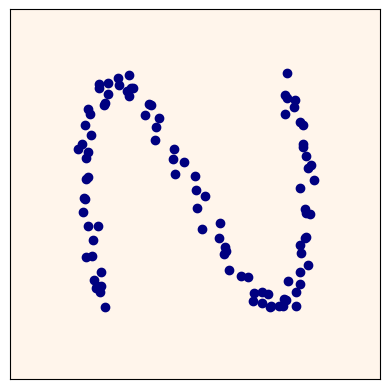

In [2]:
d = 2   # dimension of the data points

# # First dataset with 6 points
# n = 6
# y = torch.zeros((n,d), device=device)
# y[0, 0] = 0.9
# y[0, 1] = 0.2
# y[1, 0] = 0.75
# y[1, 1] = 0.8
# y[2, 0] = 0.3
# y[2, 1] = 0.4
# y[3, 0] = 0.4
# y[3, 1] = 0.7
# y[4, 0] = 0.45
# y[4, 1] = 0.75
# y[5, 0] = 0.7
# y[5, 1] = 0.5

# Second dataset with 100 points, we use this for the rest of the
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Generator

In [3]:
# class Generator(torch.nn.Module):

#     def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
#         super(Generator, self).__init__()

#         self.n_in = n_in
#         self.n_out = n_out
#         self.n_hid = n_hid
#         self.nlayers = nlayers
#         self.hidden = nn.ModuleList()

#         for n in range(nlayers):
#             n_in_t = n_in if n==0 else n_hid
#             self.hidden.append(nn.Sequential(
#             nn.Linear(n_in_t, n_hid),
#             nn.ELU(1)
#         ).to(device))

#         self.out = nn.Sequential(
#             nn.Linear(n_hid, n_out),
#             nn.Sigmoid()
#         ).to(device)

#         self.apply(self._init_weights)


#     def forward(self, x):
#         for n in range(self.nlayers):
#             x = self.hidden[n](x)
#         x = self.out(x)
#         return x


#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             torch.nn.init.xavier_uniform_(module.weight, 1.0)
#             if module.bias is not None:
#                 module.bias.data.zero_()


In [8]:
# class Generator(torch.nn.Module):
#     def __init__(self, n_z, n_hidden, n_out, device=torch.device('cpu')):
#         super(Generator, self).__init__()
#         self.device = device
#         self.n_z = n_z # the dimension of the latent space
#         self.n_hidden = n_hidden # the dimension of the hidden layer
#         self.n_out = n_out # the dimension of the output, for 2d points, n_out=2
#         self.fc1 = nn.Linear(n_z, n_hidden)
#         self.fc2 = nn.Linear(n_hidden, n_hidden)
#         self.fc3 = nn.Linear(n_hidden, n_hidden)
#         self.fc4 = nn.Linear(n_hidden, n_out)

#     def forward(self, z):
#         # use ELU for the activation function
#         h1 = F.elu(self.fc1(z))
#         h2 = F.elu(self.fc2(h1))
#         h3 = F.elu(self.fc3(h2))
#         # and sigmoid for the output layer
#         return torch.sigmoid(self.fc4(h3))

#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             nn.init.xavier_uniform_(module.weight, 1.0)
#             if module.bias is not None:
#                 module.bias.data.zero_()

In [3]:
class Generator(nn.Module):
    def __init__(self, n_z, n_hidden, n_out, device=torch.device('cpu')):
        super(Generator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_z, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, z):
        h1 = F.elu(self.fc1(z))
        h2 = F.elu(self.fc2(h1))
        h3 = F.elu(self.fc3(h2))
        return torch.tanh(self.fc4(h3))

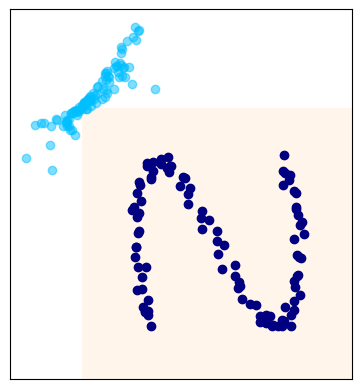

In [4]:
# plot initial config of the generator
# n_z = 10
# n_hidden = 100
# n_out = d
n_z=2 # should increase the dimension of the latent space; utile de sur paramétrer, 2 to 10
n_hidden=128 # big for 2d data; it is the most sensible
n_out=2

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# generate a batch of noise
b = 100
z = torch.randn(b, n_z, device=device)
# use generator to generate x
x = gen(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Discriminator

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, n_x, n_hid=10):
#         super(Discriminator, self).__init__()
#         self.n_hid = n_hid
#         self.n_x = n_x

#         self.fc1 = nn.Linear(n_x, n_hid)
#         self.fc2 = nn.Linear(n_hid, n_hid)
#         self.fc3 = nn.Linear(n_hid,1)

#     def forward(self, x):
#         h1 = F.elu(self.fc1(x))
#         h2 = F.elu(self.fc2(h1))
#         return torch.sigmoid(self.fc3(h2))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, device=torch.device("cpu")):
        super(Discriminator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        h1 = F.leaky_relu(self.fc1(x), 0.2)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        h3 = F.leaky_relu(self.fc3(h2), 0.2)
        return torch.sigmoid(self.fc4(h3))

In [6]:
# verify the input and output dimension of the discriminator
# n_x = d
# D = Discriminator(n_x, n_hid=10).to(device)

n_in=2
n_hidden=128
n_out=1
disc = Discriminator(n_in=n_in, n_hidden=n_hidden, n_out=n_out, device=device).to(device)

# generate a batch of data points
b = 100
x = torch.randn(b, n_in, device=device)
# use discriminator to get the probability of being real
p = disc(x)

print(p.shape)

torch.Size([100, 1])


## MMD Loss

we use linear kernel, Gaussian kernel and rational_quadratic kernel.

In [7]:
# Function to calculate the linear kernel matrix
def linear_kernel(x, y):
    return x @ y.t()

In [8]:
# Function to calculate the RBF kernel matrix
def rbf_kernel(x, y, sigma):
    pairwise_distances = torch.cdist(x, y) ** 2
    return torch.exp(-pairwise_distances / (2 * sigma ** 2))

In [9]:
# Function to calculate the rational quadratic kernel matrix
def rational_quadratic_kernel(x, y, alpha=1.0):
    pairwise_distances = torch.cdist(x, y) ** 2
    return (1 + pairwise_distances / (2 * alpha)) ** -alpha

In [10]:
# Function to calculate the unbiased MMD with linear kernel
def compute_mmd_linear(x, y):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = linear_kernel(x, x)
    K_yy = linear_kernel(y, y)
    K_xy = linear_kernel(x, y)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

In [11]:
# Function to calculate the unbiased MMD
def compute_mmd_rbf(x, y, sigma=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rbf_kernel(x, x, sigma)
    K_yy = rbf_kernel(y, y, sigma)
    K_xy = rbf_kernel(x, y, sigma)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

In [12]:
# Function to calculate the unbiased MMD with rational quadratic kernel
def compute_mmd_rational_quadratic(x, y, alpha=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rational_quadratic_kernel(x, x, alpha)
    K_yy = rational_quadratic_kernel(y, y, alpha)
    K_xy = rational_quadratic_kernel(x, y, alpha)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

## Training the MMD GAN

Epoch [100/2000], Loss D: 1.1780, Loss G: 0.0547
Epoch [200/2000], Loss D: 0.8625, Loss G: 0.0311
Epoch [300/2000], Loss D: 0.6836, Loss G: 0.0143
Epoch [400/2000], Loss D: 0.5143, Loss G: 0.0501
Epoch [500/2000], Loss D: 0.5702, Loss G: 0.0298
Epoch [600/2000], Loss D: 0.6193, Loss G: 0.0310
Epoch [700/2000], Loss D: 0.5372, Loss G: 0.0549
Epoch [800/2000], Loss D: 0.4516, Loss G: 0.0092
Epoch [900/2000], Loss D: 0.5885, Loss G: 0.0300
Epoch [1000/2000], Loss D: 0.3819, Loss G: 0.0453
Epoch [1100/2000], Loss D: 0.4690, Loss G: 0.0497
Epoch [1200/2000], Loss D: 0.3740, Loss G: 0.0568
Epoch [1300/2000], Loss D: 0.4143, Loss G: 0.0298
Epoch [1400/2000], Loss D: 0.5735, Loss G: 0.0544
Epoch [1500/2000], Loss D: 0.5798, Loss G: 0.0371
Epoch [1600/2000], Loss D: 0.4582, Loss G: 0.0578
Epoch [1700/2000], Loss D: 0.3679, Loss G: 0.0455
Epoch [1800/2000], Loss D: 0.3867, Loss G: 0.0400
Epoch [1900/2000], Loss D: 0.4516, Loss G: 0.0426
Epoch [2000/2000], Loss D: 0.5279, Loss G: 0.0345


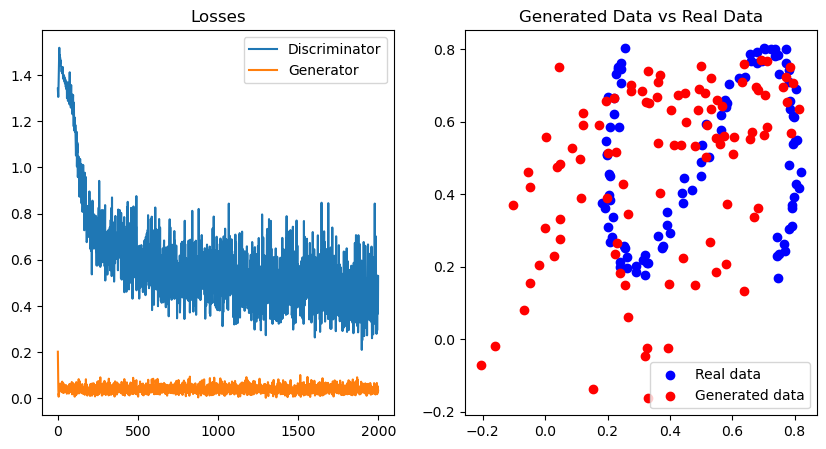

In [13]:
# Optimizers
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)
optimizer_d = optim.Adam(disc.parameters(), lr=1e-4)

# Training loop
num_epochs = 2000
batch_size = 64
losses_g = []
losses_d = []
niterD = 8
niterG = 2

for epoch in range(num_epochs):
    for i in range(0, n, batch_size):
        real_data = y[i:i+batch_size].to(device)

        # Train discriminator
        for iter in range(niterD):
            # Generate fake data
            z = torch.randn(real_data.size(0), 2).to(device)
            fake_data = gen(z)

            optimizer_d.zero_grad()
            real_output = disc(real_data)
            fake_output = disc(fake_data.detach())
            loss_d = -torch.mean(torch.log(real_output + 1e-8) + torch.log(1. - fake_output + 1e-8))
            loss_d.backward()
            optimizer_d.step()

        # Train generator
        for iter in range(niterG):
            # Generate fake data
            z = torch.randn(real_data.size(0), 2).to(device)
            fake_data = gen(z)

            optimizer_g.zero_grad()
            fake_output = disc(fake_data)
            mmd = compute_mmd_rbf(real_data, fake_data)
            # BCE with logits
            # loss gan and loss MMD
            # loss_g = -torch.mean(torch.log(fake_output + 1e-8)) + mmd
            loss_g = mmd
            loss_g.backward(retain_graph=True)
            optimizer_g.step()

    losses_g.append(loss_g.item())
    losses_d.append(loss_d.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_d, label='Discriminator')
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    fake_data = gen(z).cpu()
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show() # intermediate results, kernel and optimization parameters

linear kernel

Epoch [100/2000], Loss G: 0.0296
Epoch [200/2000], Loss G: 0.0386
Epoch [300/2000], Loss G: 0.0360
Epoch [400/2000], Loss G: 0.0353
Epoch [500/2000], Loss G: 0.0734
Epoch [600/2000], Loss G: 0.0512
Epoch [700/2000], Loss G: 0.0474
Epoch [800/2000], Loss G: 0.0422
Epoch [900/2000], Loss G: 0.0503
Epoch [1000/2000], Loss G: 0.0491
Epoch [1100/2000], Loss G: 0.0437
Epoch [1200/2000], Loss G: 0.0373
Epoch [1300/2000], Loss G: 0.0519
Epoch [1400/2000], Loss G: 0.0770
Epoch [1500/2000], Loss G: 0.0435
Epoch [1600/2000], Loss G: 0.0509
Epoch [1700/2000], Loss G: 0.0663
Epoch [1800/2000], Loss G: 0.0318
Epoch [1900/2000], Loss G: 0.0638
Epoch [2000/2000], Loss G: 0.0528


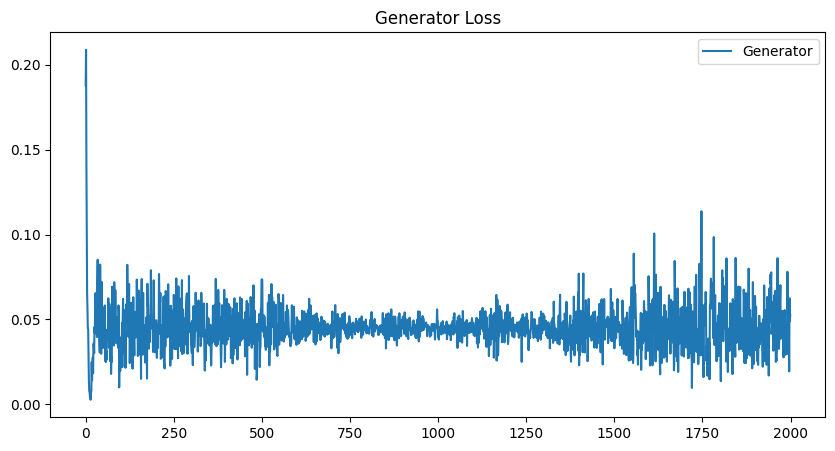

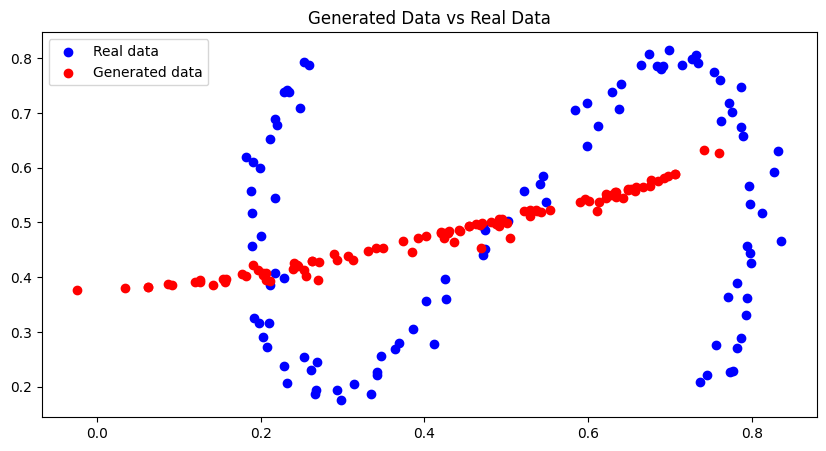

In [68]:
gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 2000
batch_size = 64
losses_g = []

for epoch in range(num_epochs):
    for i in range(0, n, batch_size):
        real_data = y[i:i+batch_size].to(device)

        # Train generator
        z = torch.randn(real_data.size(0), 2).to(device)
        fake_data = gen(z)

        optimizer_g.zero_grad()
        mmd = compute_mmd_linear(real_data, fake_data)
        loss_g = mmd
        loss_g.backward()
        optimizer_g.step()

    losses_g.append(loss_g.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

plt.figure(figsize=(10, 5))
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    fake_data = gen(z).cpu()
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show()


rbf kernel

Epoch [100/2000], Loss G: 0.0415
Epoch [200/2000], Loss G: 0.0271
Epoch [300/2000], Loss G: 0.0360
Epoch [400/2000], Loss G: 0.0264
Epoch [500/2000], Loss G: 0.0424
Epoch [600/2000], Loss G: 0.0441
Epoch [700/2000], Loss G: 0.0430
Epoch [800/2000], Loss G: 0.0386
Epoch [900/2000], Loss G: 0.0253
Epoch [1000/2000], Loss G: 0.0341
Epoch [1100/2000], Loss G: 0.0541
Epoch [1200/2000], Loss G: 0.0166
Epoch [1300/2000], Loss G: 0.0244
Epoch [1400/2000], Loss G: 0.0262
Epoch [1500/2000], Loss G: 0.0482
Epoch [1600/2000], Loss G: 0.0624
Epoch [1700/2000], Loss G: 0.0826
Epoch [1800/2000], Loss G: 0.0372
Epoch [1900/2000], Loss G: 0.0458
Epoch [2000/2000], Loss G: 0.0122


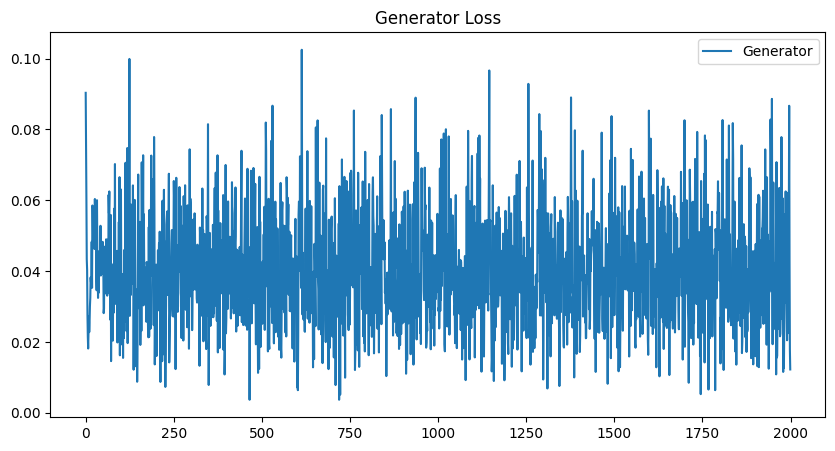

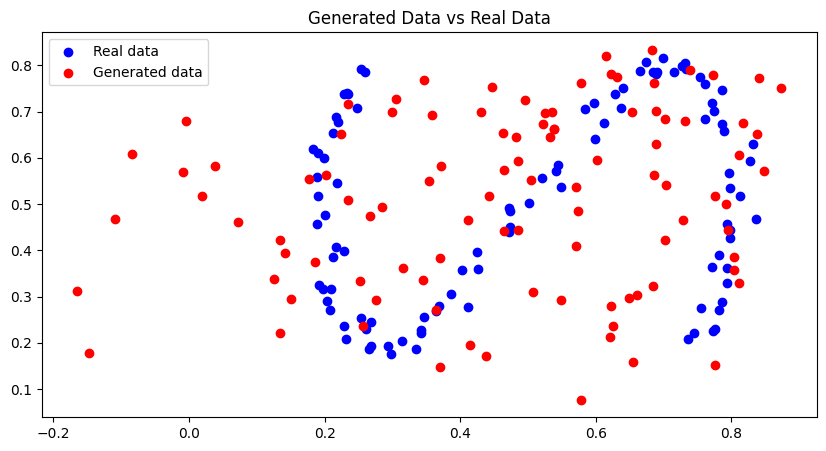

In [69]:
gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 2000
batch_size = 64
losses_g = []

# take all the points instead of a batch
for epoch in range(num_epochs):
    for i in range(0, n, batch_size):
        real_data = y[i:i+batch_size].to(device)

        # Train generator
        z = torch.randn(real_data.size(0), 2).to(device) # batch size
        fake_data = gen(z)

        optimizer_g.zero_grad()
        mmd = compute_mmd_rbf(real_data, fake_data)
        loss_g = mmd
        loss_g.backward()
        optimizer_g.step()

    losses_g.append(loss_g.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

plt.figure(figsize=(10, 5))
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    fake_data = gen(z).cpu()
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show()

Epoch [100/3000], Loss G: 0.0442
Epoch [200/3000], Loss G: 0.0536
Epoch [300/3000], Loss G: 0.0403
Epoch [400/3000], Loss G: 0.0372
Epoch [500/3000], Loss G: 0.0210
Epoch [600/3000], Loss G: 0.0533
Epoch [700/3000], Loss G: 0.0143
Epoch [800/3000], Loss G: 0.0613
Epoch [900/3000], Loss G: 0.0743
Epoch [1000/3000], Loss G: 0.0452
Epoch [1100/3000], Loss G: 0.0820
Epoch [1200/3000], Loss G: 0.0220
Epoch [1300/3000], Loss G: 0.0273
Epoch [1400/3000], Loss G: 0.0257
Epoch [1500/3000], Loss G: 0.0408
Epoch [1600/3000], Loss G: 0.0457
Epoch [1700/3000], Loss G: 0.0440
Epoch [1800/3000], Loss G: 0.0238
Epoch [1900/3000], Loss G: 0.0354
Epoch [2000/3000], Loss G: 0.0242
Epoch [2100/3000], Loss G: 0.0265
Epoch [2200/3000], Loss G: 0.0511
Epoch [2300/3000], Loss G: 0.0653
Epoch [2400/3000], Loss G: 0.0434
Epoch [2500/3000], Loss G: 0.0280
Epoch [2600/3000], Loss G: 0.0360
Epoch [2700/3000], Loss G: 0.0626
Epoch [2800/3000], Loss G: 0.0148
Epoch [2900/3000], Loss G: 0.0330
Epoch [3000/3000], Loss

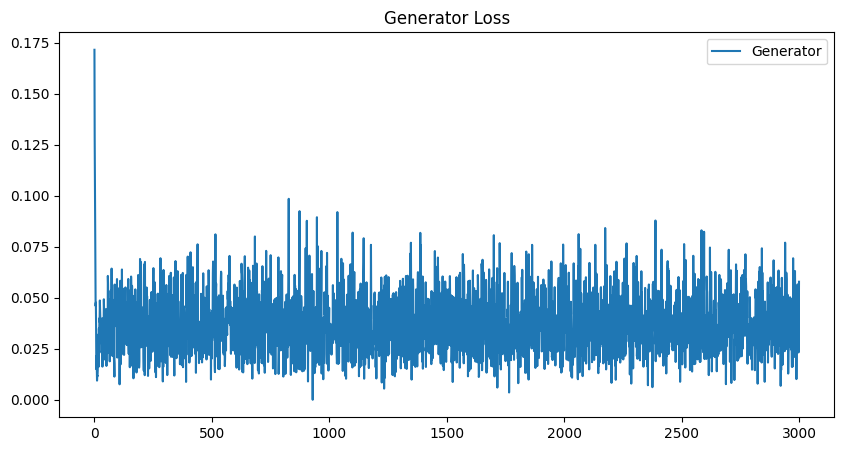

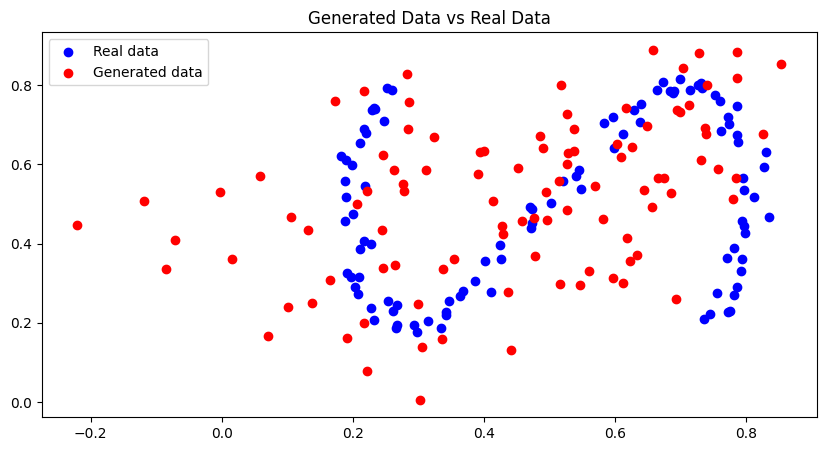

In [70]:
gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 3000
batch_size = 64
losses_g = []

for epoch in range(num_epochs):
    for i in range(0, n, batch_size):
        real_data = y[i:i+batch_size].to(device)

        # Train generator
        z = torch.randn(real_data.size(0), 2).to(device)
        fake_data = gen(z)

        optimizer_g.zero_grad()
        mmd = compute_mmd_rational_quadratic(real_data, fake_data)
        loss_g = mmd
        loss_g.backward()
        optimizer_g.step()

    losses_g.append(loss_g.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

plt.figure(figsize=(10, 5))
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    fake_data = gen(z).cpu()
    plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show()